<a href="https://colab.research.google.com/github/aulphin/S-GuISE/blob/main/Rise_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/.shortcut-targets-by-id/1ho2ZxmQ9ohP8W6JjYS1G-B3VSrKWEEgi/New-Project


# Randomized Input Sampling for Explanations (RISE)

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [ ]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [ ]:
from keras.preprocessing import image

In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

---

## RISE

In [ ]:
########### Generating Mask ####################

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size)
    return masks

## Running explanations

In [ ]:

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))

    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)

    max_probs = [max(sublist) for sublist in preds]

    #print(max_probs)

    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)

    sal = sal / N    #/ p1
    return sal

In [ ]:
model = Model()

In [ ]:
batch_size = 100

In [ ]:

#### No. of mask generation
N = 256
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)

Generating masks: 100%|██████████| 256/256 [00:00<00:00, 372.89it/s]


In [ ]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [ ]:

image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_img.jpg'

In [ ]:
#image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/junco.jpg'
img, x = load_img(image_path)

In [ ]:
#plt.imshow(img)

In [ ]:
#print(x.shape)

In [ ]:
sal = explain(model, x, masks)

Explaining:   0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 1s 98ms/step


Explaining:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

4/4 [==============================] - 0s 82ms/step


Explaining:  67%|██████▋   | 2/3 [00:02<00:00,  1.05it/s]

2/2 [==============================] - 0s 79ms/step


Explaining: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


experiment with different dataset

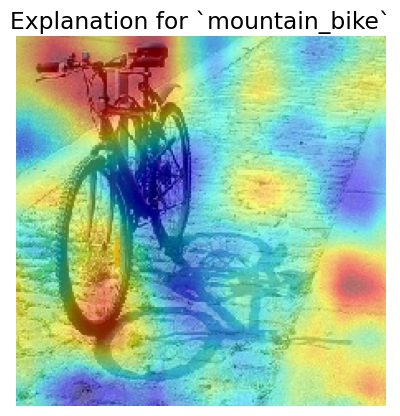

In [ ]:
class_idx = 671
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
saliency = sal[class_idx]
plt.imshow(saliency, cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

In [ ]:
# Save the saliency map image
saliency_image_path = 'saliency_image1.png'
plt.imsave(saliency_image_path, saliency, cmap='jet')

# Implementing Rise method Insertion and Deletion Score

In [ ]:
###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [ ]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [ ]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages

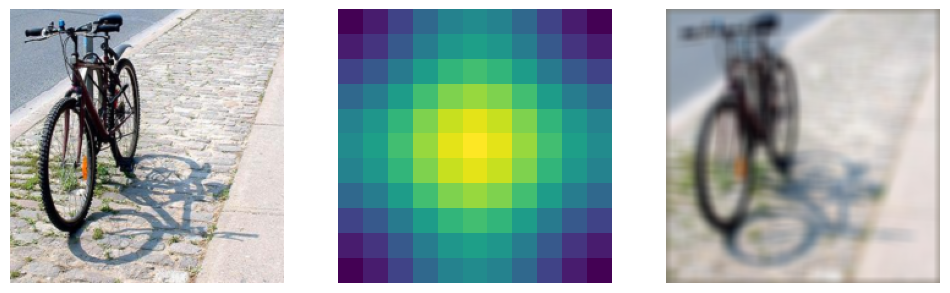

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_img.jpg')
#img= read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000065.jpg')
#img = read_tensor('gil.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
######### Causal Metrics #######
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

########### Evaluating Metrics for Single Image #######

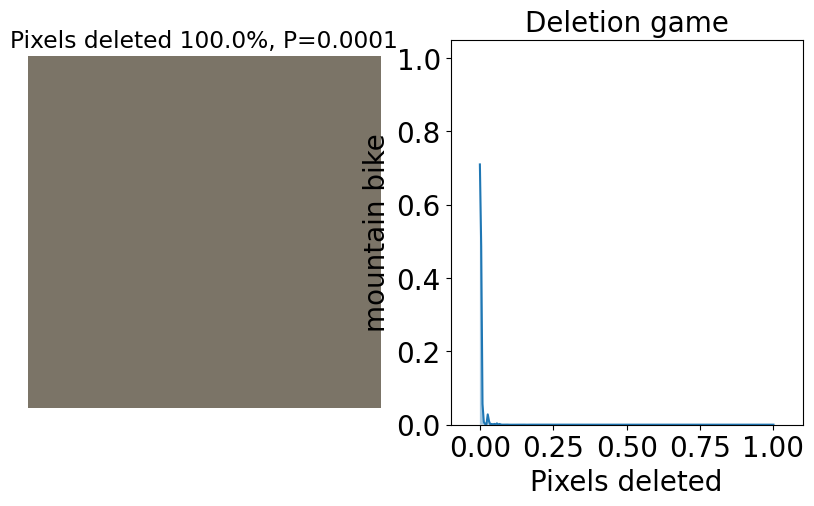

AUC: 0.004414775679606464


In [ ]:
h = deletion.single_run(img, sal, verbose=1)

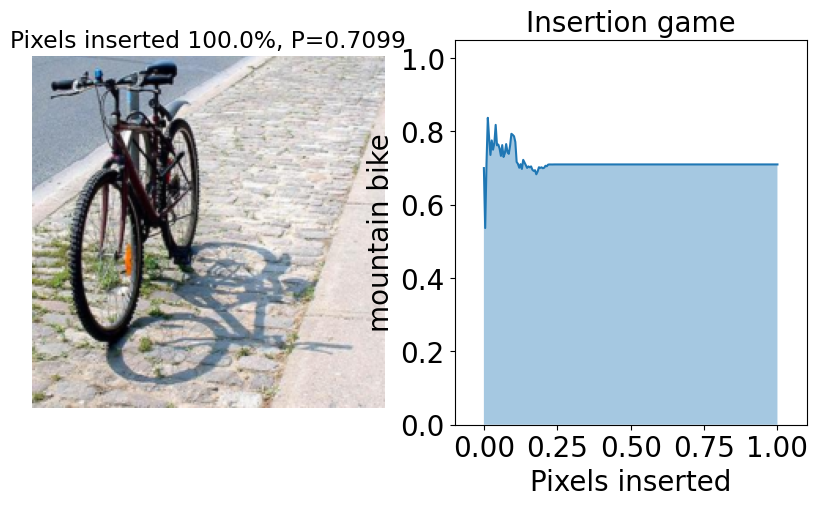

AUC: 0.7138697982632688


In [ ]:
h = insertion.single_run(img, sal, verbose=1)

In [ ]:
# auc_score = auc(h)
# print('AUC of Insertion Metric:', auc_score)

# Evaluation Metrics: Computing Ground truth mask

In [ ]:
gt_mask_path ='/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_gtm.png'
saliency_image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/saliency_image1.png'

In [ ]:
import cv2
import numpy as np

def compute_mGT(gt_mask_path, saliency_image_path):

    # Load and resize to match the dimensions images
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    saliency_image = cv2.imread(saliency_image_path, cv2.IMREAD_GRAYSCALE)

    gt_mask_resized = cv2.resize(gt_mask, (saliency_image.shape[1], saliency_image.shape[0]))


    # Number of white pixels in GT mask computing as p
    p = np.sum(gt_mask_resized == 255)
    print(f"number of white pixels in ground truth mask: {p}")

    # Flatten the saliency mask pixels and sorting in decreasing order
    flat_saliency = saliency_image.flatten()
    print(flat_saliency)
    sorted_indices = np.argsort(flat_saliency)[::-1]

    # Select the indices of the top p pixels from the saliency map
    top_p_indices = sorted_indices[:p]
    print(top_p_indices)

    # Now create the binary mask for the saliency map
    saliency_mask = np.zeros_like(flat_saliency, dtype=np.uint8)
    saliency_mask[top_p_indices] = 1
    saliency_mask = saliency_mask.reshape(saliency_image.shape)

    # compute number of white pixels in saliency_mask
    c = np.sum(saliency_mask == 1)
    print(f"number of white pixels in saliency mask: {c}")

    # Create ground truth binary mask
    gt_binary_mask = np.where(gt_mask_resized == 255, 1, 0).astype(np.uint8)
    print(f"number of white pixels in ground truth binary mask: {np.sum(gt_binary_mask ==1)}")

    # Compute the number of overlapping positive pixels
    n = np.sum((gt_binary_mask == 1) & (saliency_mask == 1))

    # Compute the mGT metric
    mGT = n / p if p != 0 else 0  # To avoid division by zero

    return mGT


In [ ]:
# Compute mGT
mGT = compute_mGT(gt_mask_path, saliency_image_path)
print(f'mGT: {mGT}')


number of white pixels in ground truth mask: 8521
[210 206 204 ... 210 208 206]
[ 6715  6647 39198 ... 46792 31137 19171]
number of white pixels in saliency mask: 8521
number of white pixels in ground truth binary mask: 8521
mGT: 0.15362046708132848


############end#################

# Evaluation Metrics DTD and DTI

In [ ]:
target_class_idx = 283

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Function to load and preprocess the original image
def load_and_preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    return image_tensor

# Load and preprocess the original image
original_image_tensor = load_and_preprocess_image('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000122.jpg') # Replace with your image path


In [ ]:
# Model_predict function to take a PyTorch tensor as input
def model_predict(image_tensor, target_class_idx):
    # Make sure the tensor is on the correct device
    image_tensor = image_tensor.to(device)

    # Get the model's output
    with torch.no_grad():
        output = model(image_tensor)

    # Extract the probability for the target class
    probability = output.cpu().numpy()[0][target_class_idx]
    #print(probability)
    return probability


In [ ]:
def get_image_mean_values():
    return [0.485, 0.456, 0.406]

In [ ]:
def remove_pixels_by_saliency(original_image_tensor, saliency_map, threshold):
    # Assume saliency_map is a PyTorch tensor. If it's a NumPy array, convert it to a PyTorch tensor.
    if isinstance(saliency_map, np.ndarray):
        saliency_map = torch.from_numpy(saliency_map).float()
    if len(saliency_map.shape) > 2:  # If saliency_map has more than 2 dimensions, take the first image.
        saliency_map = saliency_map[0]

    # Normalize the saliency map to the range [0, 1]
    normalized_saliency = saliency_map / torch.max(saliency_map)

    # Create a mask for pixels to keep (True for keeping, False for removing)
    mask = normalized_saliency  <threshold

    # Replicate the mask for all color channels
    mask = mask.unsqueeze(0)  # Add a channel dimension
    mask_replicated_across_channels = mask.repeat(original_image_tensor.size(1), 1, 1)  # Repeat the mask for each color channel

    # Move the mask to the same device as the original_image_tensor
    mask_replicated_across_channels = mask_replicated_across_channels.to(original_image_tensor.device)

    # Clone the original image tensor for modification
    modified_image_tensor = original_image_tensor.clone()

    # Prepare a tensor of mean values for replacement
    mean_values_tensor = torch.tensor(get_image_mean_values(), device=original_image_tensor.device).view(1, 3, 1, 1)

    # Expand mean values tensor to match the dimensions of the image tensor
    expanded_mean_values = mean_values_tensor.expand_as(original_image_tensor)

    # Apply the mask: Replace pixels where the mask is False with the mean values
    modified_image_tensor[:, ~mask_replicated_across_channels] = expanded_mean_values[:, ~mask_replicated_across_channels]

    return modified_image_tensor


In [ ]:
# Initialize variables to hold the results
model_confidences = []
thresholds_used = []  # This will store the thresholds used at each step

# Perform the perturbation analysis
# The for loop starts at 1.0 and decrements by 0.01 on each iteration
for current_threshold in np.arange(1.0, 0.0, -0.01):
    # Remove pixels based on the current threshold
    modified_image_tensor = remove_pixels_by_saliency(original_image_tensor, sal, current_threshold)

    # Get the model's prediction for the modified image
    confidence = model_predict(modified_image_tensor, target_class_idx)

    # Store the model's confidence
    model_confidences.append(confidence)

    # Record the threshold used
    thresholds_used.append(current_threshold)


print(thresholds_used)
print(model_confidences)


[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.9299999999999999, 0.9199999999999999, 0.9099999999999999, 0.8999999999999999, 0.8899999999999999, 0.8799999999999999, 0.8699999999999999, 0.8599999999999999, 0.8499999999999999, 0.8399999999999999, 0.8299999999999998, 0.8199999999999998, 0.8099999999999998, 0.7999999999999998, 0.7899999999999998, 0.7799999999999998, 0.7699999999999998, 0.7599999999999998, 0.7499999999999998, 0.7399999999999998, 0.7299999999999998, 0.7199999999999998, 0.7099999999999997, 0.6999999999999997, 0.6899999999999997, 0.6799999999999997, 0.6699999999999997, 0.6599999999999997, 0.6499999999999997, 0.6399999999999997, 0.6299999999999997, 0.6199999999999997, 0.6099999999999997, 0.5999999999999996, 0.5899999999999996, 0.5799999999999996, 0.5699999999999996, 0.5599999999999996, 0.5499999999999996, 0.5399999999999996, 0.5299999999999996, 0.5199999999999996, 0.5099999999999996, 0.49999999999999956, 0.48999999999999955, 0.47999999999999954, 0.46999999999999953, 0.459999999999

In [ ]:
# Adjust the calculation to use thresholds_used and model_confidences
# Since thresholds directly correlate with the removal process, they replace the concept of fraction_pixels_removed

# Assuming thresholds_used is a list of saliency thresholds at which pixels were removed
# and model_confidences are the corresponding model confidences

# Ensure thresholds_used is a numpy array for processing
thresholds_array = np.array(thresholds_used)

# Calculate the area under the model confidence curve as a function of saliency threshold
# This will give us an indication of how model confidence changes as more salient pixels are removed
area_under_confidence_curve = np.trapz(model_confidences, thresholds_array)

# Normalize the area by the range of thresholds to get the average drop in confidence
# This normalization makes the metric independent of the number of steps or the exact range of thresholds used
average_drop_in_confidence = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])

print(f"Average drop in model confidence per unit increase in saliency threshold: {average_drop_in_confidence}")
#print(area_under_confidence_curve )



Average drop in model confidence per unit increase in saliency threshold: 0.03310213815947086


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that the `thresholds_array` and `model_confidences_array` are numpy arrays
# If they are in descending order, they need to be reversed for correct plotting and AUC calculation
thresholds_array = np.array(thresholds_used)[::-1]  # Reverse the thresholds array
model_confidences_array = np.array(model_confidences)[::-1]  # Reverse the model confidences array

# Recalculate AUC with the arrays in ascending order
area_under_confidence_curve = np.trapz(model_confidences_array, thresholds_array)

# Normalize the area by the range of thresholds
roc_auc = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])



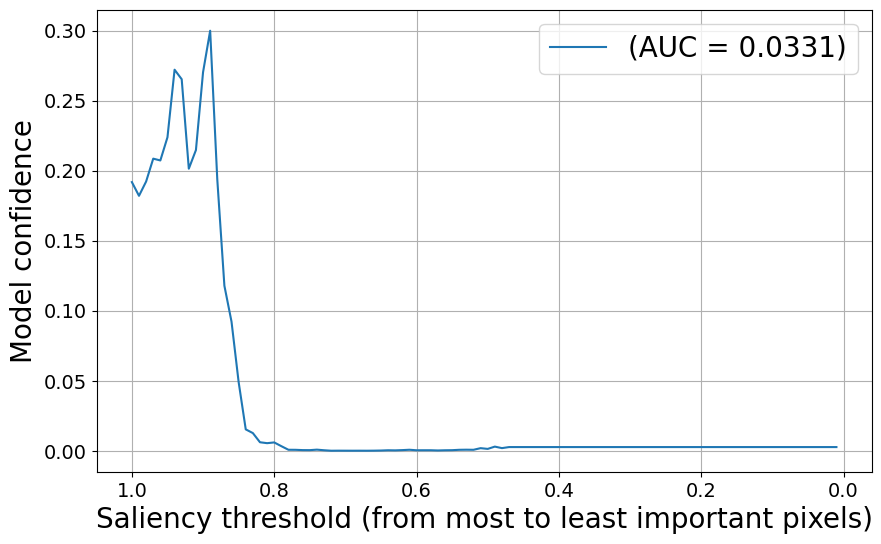

The Area Under the Curve is: 0.0331


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume thresholds_array and model_confidences_array are defined and filled with data
# Assume roc_auc is calculated and holds the AUC value

# Set font sizes
plt.rcParams.update({'font.size': 14})  # Adjusts the font size of all plot elements
label_fontsize = 20  # Font size for x and y labels
legend_fontsize = 20  # Font size for the legend

# Plot the Model Confidence Curve using the thresholds and model confidences
plt.figure(figsize=(10, 6))
plt.plot(thresholds_array, model_confidences_array, label=f'(AUC = {roc_auc:.4f})')
#plt.title('Model Confidence as Salient Pixels are Removed', fontsize=title_fontsize)
plt.xlabel('Saliency threshold (from most to least important pixels)', fontsize=label_fontsize)
plt.ylabel('Model confidence', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing thresholds from left to right
plt.show()

print(f"The Area Under the Curve is: {roc_auc:.4f}")


New Pixel Insertion Method

In [ ]:
def add_pixels_by_saliency(original_image_tensor, saliency_map, threshold):
    # Assume saliency_map is a PyTorch tensor. If it's a NumPy array, convert it to a PyTorch tensor.
    if isinstance(saliency_map, np.ndarray):
        saliency_map = torch.from_numpy(saliency_map).float()
    if len(saliency_map.shape) > 2:  # If saliency_map has more than 2 dimensions, take the first image.
        saliency_map = saliency_map[0]

    # Normalize the saliency map to the range [0, 1]
    normalized_saliency = saliency_map / torch.max(saliency_map)

    # Create a mask for pixels to keep (True for keeping, False for removing)
    mask = normalized_saliency  >=threshold

    # Replicate the mask for all color channels
    mask = mask.unsqueeze(0)  # Add a channel dimension
    mask_replicated_across_channels = mask.repeat(original_image_tensor.size(1), 1, 1)  # Repeat the mask for each color channel

    # Move the mask to the same device as the original_image_tensor
    mask_replicated_across_channels = mask_replicated_across_channels.to(original_image_tensor.device)

     # Ensure the mask tensor is on the same device as the original image tensor
    mask_tensor = mask_replicated_across_channels.to(original_image_tensor.device)

    # Clone the original image tensor for modification
    modified_image_tensor = original_image_tensor.clone()

     # Set the pixels where the mask is False (salient pixels above the threshold) to zero
    modified_image_tensor[:, ~mask_tensor] = 0

    # # Prepare a tensor of mean values for replacement
    # mean_values_tensor = torch.tensor(get_image_mean_values(), device=original_image_tensor.device).view(1, 3, 1, 1)

    # # Expand mean values tensor to match the dimensions of the image tensor
    # expanded_mean_values = mean_values_tensor.expand_as(original_image_tensor)

    # # Apply the mask: Replace pixels where the mask is False with the mean values
    # modified_image_tensor[:, ~mask_replicated_across_channels] = expanded_mean_values[:, ~mask_replicated_across_channels]

    return modified_image_tensor


In [ ]:
# Initialize variables to hold the results
model_confidences = []
thresholds_used = []  # This will store the thresholds used at each step

# Perform the perturbation analysis
# The for loop starts at 1.0 and decrements by 0.01 on each iteration
for current_threshold in np.arange(1.0, 0.0, -0.01):
    # Remove pixels based on the current threshold
    modified_image_tensor = add_pixels_by_saliency(original_image_tensor, sal, current_threshold)

    # Get the model's prediction for the modified image
    confidence = model_predict(modified_image_tensor, target_class_idx)

    # Store the model's confidence
    model_confidences.append(confidence)

    # Record the threshold used
    thresholds_used.append(current_threshold)


print(thresholds_used)
print(model_confidences)


[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.9299999999999999, 0.9199999999999999, 0.9099999999999999, 0.8999999999999999, 0.8899999999999999, 0.8799999999999999, 0.8699999999999999, 0.8599999999999999, 0.8499999999999999, 0.8399999999999999, 0.8299999999999998, 0.8199999999999998, 0.8099999999999998, 0.7999999999999998, 0.7899999999999998, 0.7799999999999998, 0.7699999999999998, 0.7599999999999998, 0.7499999999999998, 0.7399999999999998, 0.7299999999999998, 0.7199999999999998, 0.7099999999999997, 0.6999999999999997, 0.6899999999999997, 0.6799999999999997, 0.6699999999999997, 0.6599999999999997, 0.6499999999999997, 0.6399999999999997, 0.6299999999999997, 0.6199999999999997, 0.6099999999999997, 0.5999999999999996, 0.5899999999999996, 0.5799999999999996, 0.5699999999999996, 0.5599999999999996, 0.5499999999999996, 0.5399999999999996, 0.5299999999999996, 0.5199999999999996, 0.5099999999999996, 0.49999999999999956, 0.48999999999999955, 0.47999999999999954, 0.46999999999999953, 0.459999999999

In [ ]:
# Ensure thresholds_used is a numpy array for processing
thresholds_array = np.array(thresholds_used)

# Calculate the area under the model confidence curve as a function of saliency threshold
# This will give us an indication of how model confidence changes as more salient pixels are removed
area_under_confidence_curve = np.trapz(model_confidences, thresholds_array)

# Normalize the area by the range of thresholds to get the average drop in confidence
# This normalization makes the metric independent of the number of steps or the exact range of thresholds used
average_inc_in_confidence = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])

print(f"Average increase in model confidence per unit increase in saliency threshold: {average_inc_in_confidence}")
#print(area_under_confidence_curve )



Average increase in model confidence per unit increase in saliency threshold: 0.17421333253362112


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# The `thresholds_array` and `model_confidences_array` are numpy arrays
# They are in descending order, we need to be reversed for correct plotting and AUC calculation
thresholds_array = np.array(thresholds_used)[::-1]  # Reverse the thresholds array
model_confidences_array = np.array(model_confidences)[::-1]  # Reverse the model confidences array

# Recalculate AUC with the arrays in ascending order
area_under_confidence_curve = np.trapz(model_confidences_array, thresholds_array)

# Normalize the area by the range of thresholds
roc_auc = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])



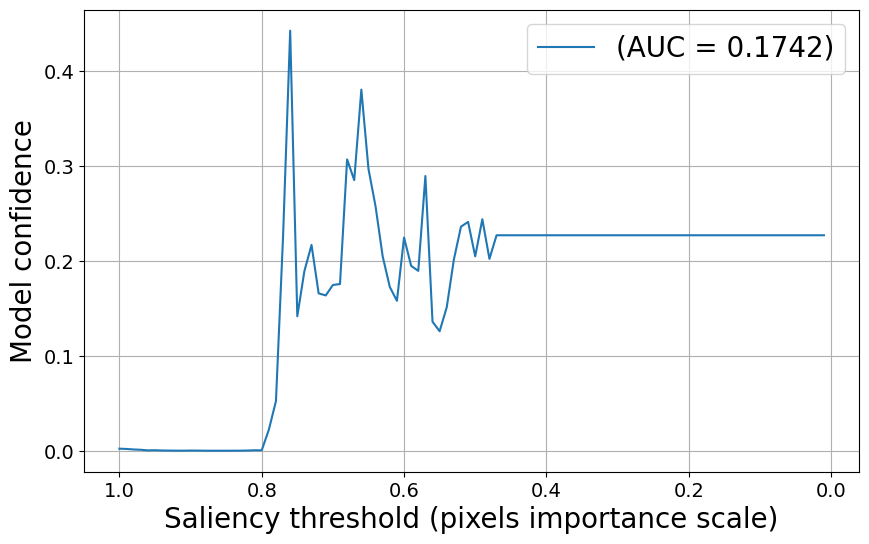

The Area Under the Curve is: 0.1742


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# thresholds_array and model_confidences_array are defined and filled with data
# roc_auc is calculated and holds the AUC value

# Set font sizes
plt.rcParams.update({'font.size': 14})  # Adjusts the font size of all plot elements
label_fontsize = 20  # Font size for x and y labels
legend_fontsize = 20  # Font size for the legend

# Plot the Model Confidence Curve using the thresholds and model confidences
plt.figure(figsize=(10, 6))
plt.plot(thresholds_array, model_confidences_array, label=f'(AUC = {roc_auc:.4f})')
#plt.title('Model Confidence as Salient Pixels are Removed', fontsize=title_fontsize)
plt.xlabel('Saliency threshold (pixels importance scale)', fontsize=label_fontsize)
plt.ylabel('Model confidence', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing thresholds from left to right
plt.show()

print(f"The Area Under the Curve is: {roc_auc:.4f}")
